<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry Dendrite Segmentation Tutorial for Beginners

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/dendrite-segmentation/dendrite_segmentation.ipynb)

This introduction uses Foundry to:


1.   Load data from Foundry
2.   Build a predictuve U-Net model
3. Create augmented data to use with the model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
    import google.colab
    no_local_server=True
    no_browser=True
    globus=False
except: # when not in google colab
    no_local_server=False
    no_browser=False
    globus=True

# Installing Foundry and Other Modules
First we'll need to install Foundry as well as a few other packages. If you're using Google Colab, this code block will install these packages into the Colab environment.

If you are running locally, it will install these modules onto your machine if you do not already have them. We also have a [requirements file](https://github.com/MLMI2-CSSI/foundry/tree/main/examples/dendrite-segmentation) included with this notebook. You can run `pip install -r requirements.txt` in your terminal to set up your environment locally.

In [2]:
!pip install scikit-learn
!pip install foundry_ml
!pip install scikit-image
!pip install tensorflow
!pip install keras-unet
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 25.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 19.5 MB/s eta 0:00:00


  Using cached pandas-1.2.2.tar.gz (5.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [10 lines of output]
      /var/folders/pt/yt32tjj14wnd61myqn_0mj6r0000gn/T/H5closer_08_171.c:2:5: error: call to undeclared function 'H5close'; ISO C99 and later do not support implicit function declarations [-Wimplicit-function-declaration]
          H5close();
          ^
      1 error generated.
      * Using Python 3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:20) [Clang 12.0.5 (clang-1205.0.22.11)]
      * USE_PKGCONFIG: False
      .. ERROR:: Could not find a local HDF5 installation.
         You may need to explicitly state where your local HDF5 headers and
         library can be found by setting th

# Importing Packages
Now we can import Foundry, which will allow us to load the data. 

We'll be using [scikit-image](https://scikit-image.org/) for image processing; [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) to create our model; and [pandas](https://pandas.pydata.org/), [OpenCV](https://pypi.org/project/opencv-python/), and [NumPy ](https://numpy.org/)to work with our data.

In [6]:
from foundry.foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import get_augmented

2023-11-30 10:42:29.671551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [7]:
f = Foundry(globus=globus)

# Loading the Data
Now we can use our instance of Foundry to access the data. We'll use the `search()` function to search for the dataset by it's name.

In [9]:
datasets = f.search("foundry_stan_segmentation_v1.1")

By default, search returns the results as a dictionary of FoundryDataset objects.

In [10]:
datasets

,dataset_name,title,year,DOI
0,foundry_stan_segmentation_v1.1,Dataset for Semantic Segmentation of Dendrites...,2021,10.18126/d4kn-cz3p


In this case, we got a single result, which we can access the `FoundryDataset` object using the `get_dataset_by_name()` funtion.

In [13]:
dataset = datasets.get_dataset_by_name("foundry_stan_segmentation_v1.1")

We can then load the data into memory as a dictionary,

In [17]:
res = dataset.get_as_dict()
X = res['train']['input']['train/input']
y = res['train']['target']['train/output']

# Visualizing the Data

Now that we've loaded the data, let's take a look!

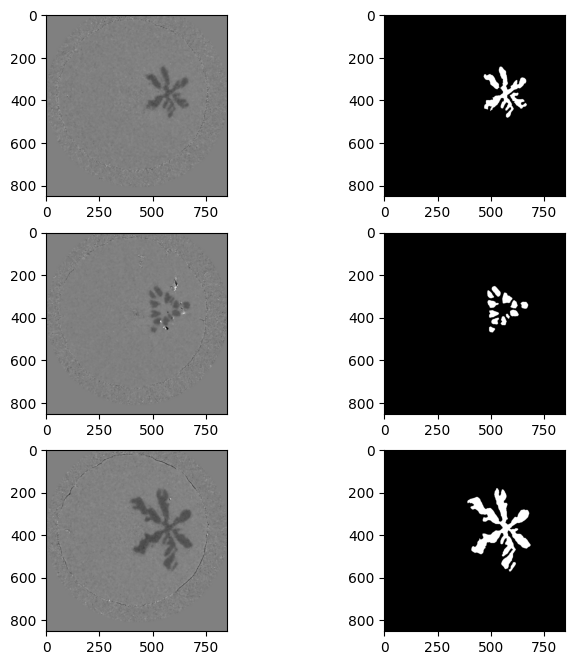

In [18]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Building a Model
## Resize to Match UNet
UNet requires images to be of a size multiple of 32, so we'll resize them here.

In [19]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size)) 
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) 
     for mask in y])

In [20]:
y_r.shape

(30, 320, 320, 3)

## Create UNet Model

In [21]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 320, 320, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 spatial_dropout2d (Spatial  (None, 320, 320, 16)         0         ['batch_normalization[0][0

 anspose)                                                           ]                             
                                                                                                  
 concatenate (Concatenate)   (None, 40, 40, 256)          0         ['conv2d_transpose[0][0]',    
                                                                     'batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 40, 40, 128)          294912    ['concatenate[0][0]']         
                                                                                                  
 batch_normalization_10 (Ba  (None, 40, 40, 128)          512       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

# Preview the Segmentation Task

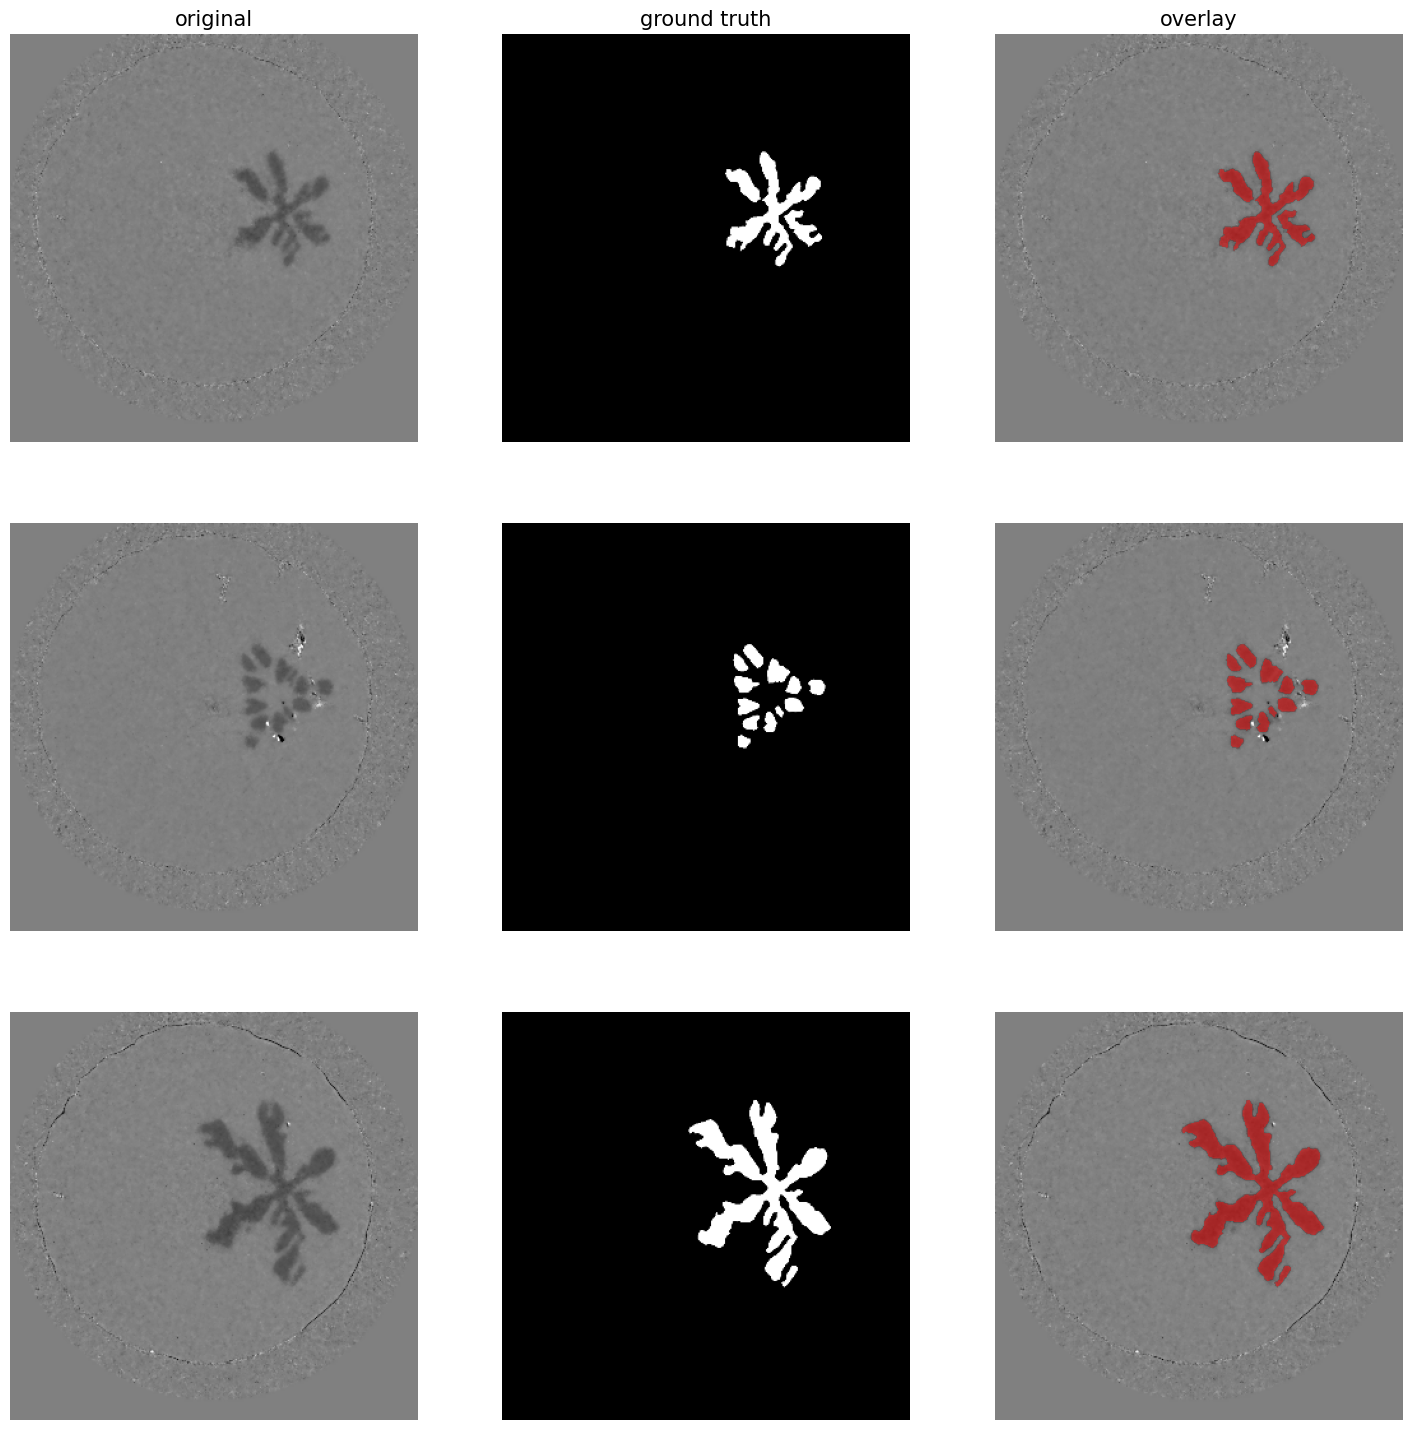

In [23]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)

# Create a Generator with Augmented Images

In [24]:
X_r.shape

(30, 320, 320, 3)

In [25]:
y_r.shape

(30, 320, 320, 3)

In [26]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


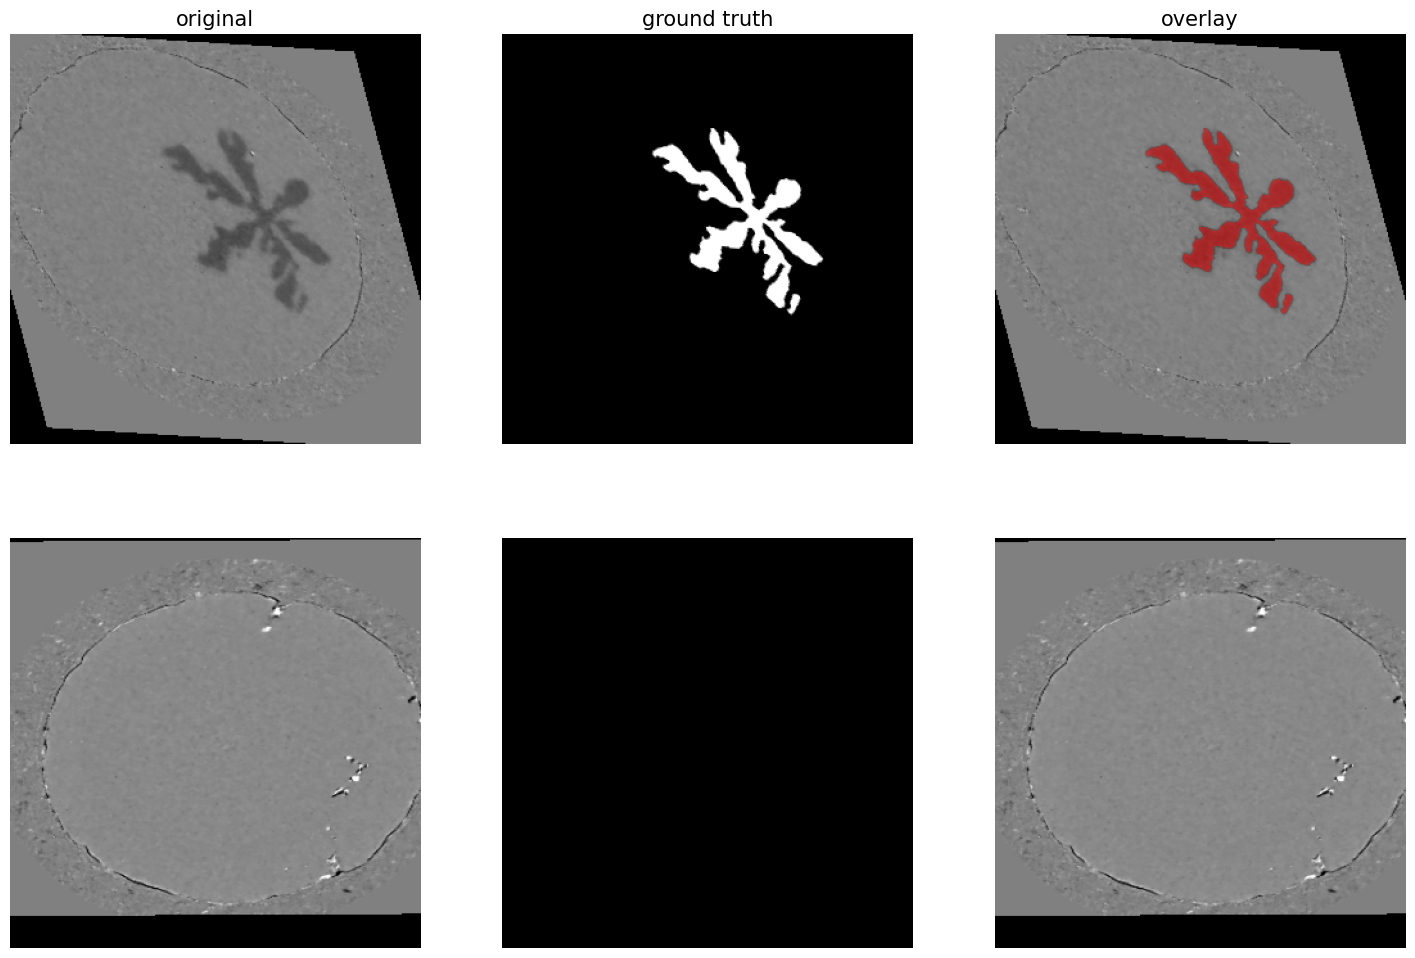

In [27]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [28]:
model.compile(
    optimizer="adam", 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [29]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

Epoch 1/10
200/200 [==============================] - 248s 1s/step - loss: 0.3855 - mean_io_u: 0.5010
Epoch 2/10
200/200 [==============================] - 247s 1s/step - loss: 0.1197 - mean_io_u: 0.5851
Epoch 3/10
200/200 [==============================] - 247s 1s/step - loss: 0.0562 - mean_io_u: 0.6207
Epoch 4/10
200/200 [==============================] - 246s 1s/step - loss: 0.0423 - mean_io_u: 0.5936
Epoch 5/10
200/200 [==============================] - 256s 1s/step - loss: 0.0251 - mean_io_u: 0.5976
Epoch 6/10
200/200 [==============================] - 260s 1s/step - loss: 0.0316 - mean_io_u: 0.5536
Epoch 7/10
200/200 [==============================] - 237s 1s/step - loss: 0.0211 - mean_io_u: 0.5388
Epoch 8/10
200/200 [==============================] - 245s 1s/step - loss: 0.0211 - mean_io_u: 0.5207
Epoch 9/10
200/200 [==============================] - 276s 1s/step - loss: 0.0181 - mean_io_u: 0.5108
Epoch 10/10
200/200 [==============================] - 260s 1s/step - loss: 0.0154

In [30]:
model_name = f"./{new_size}x{new_size}-model.h5"
model.save(model_name) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
model = tf.keras.models.load_model(model_name)

# Run Predict on Images

In [32]:
y_pred = model.predict(X_r)

1/1 [==============================] - 4s 4s/step


# Check Performance Visually

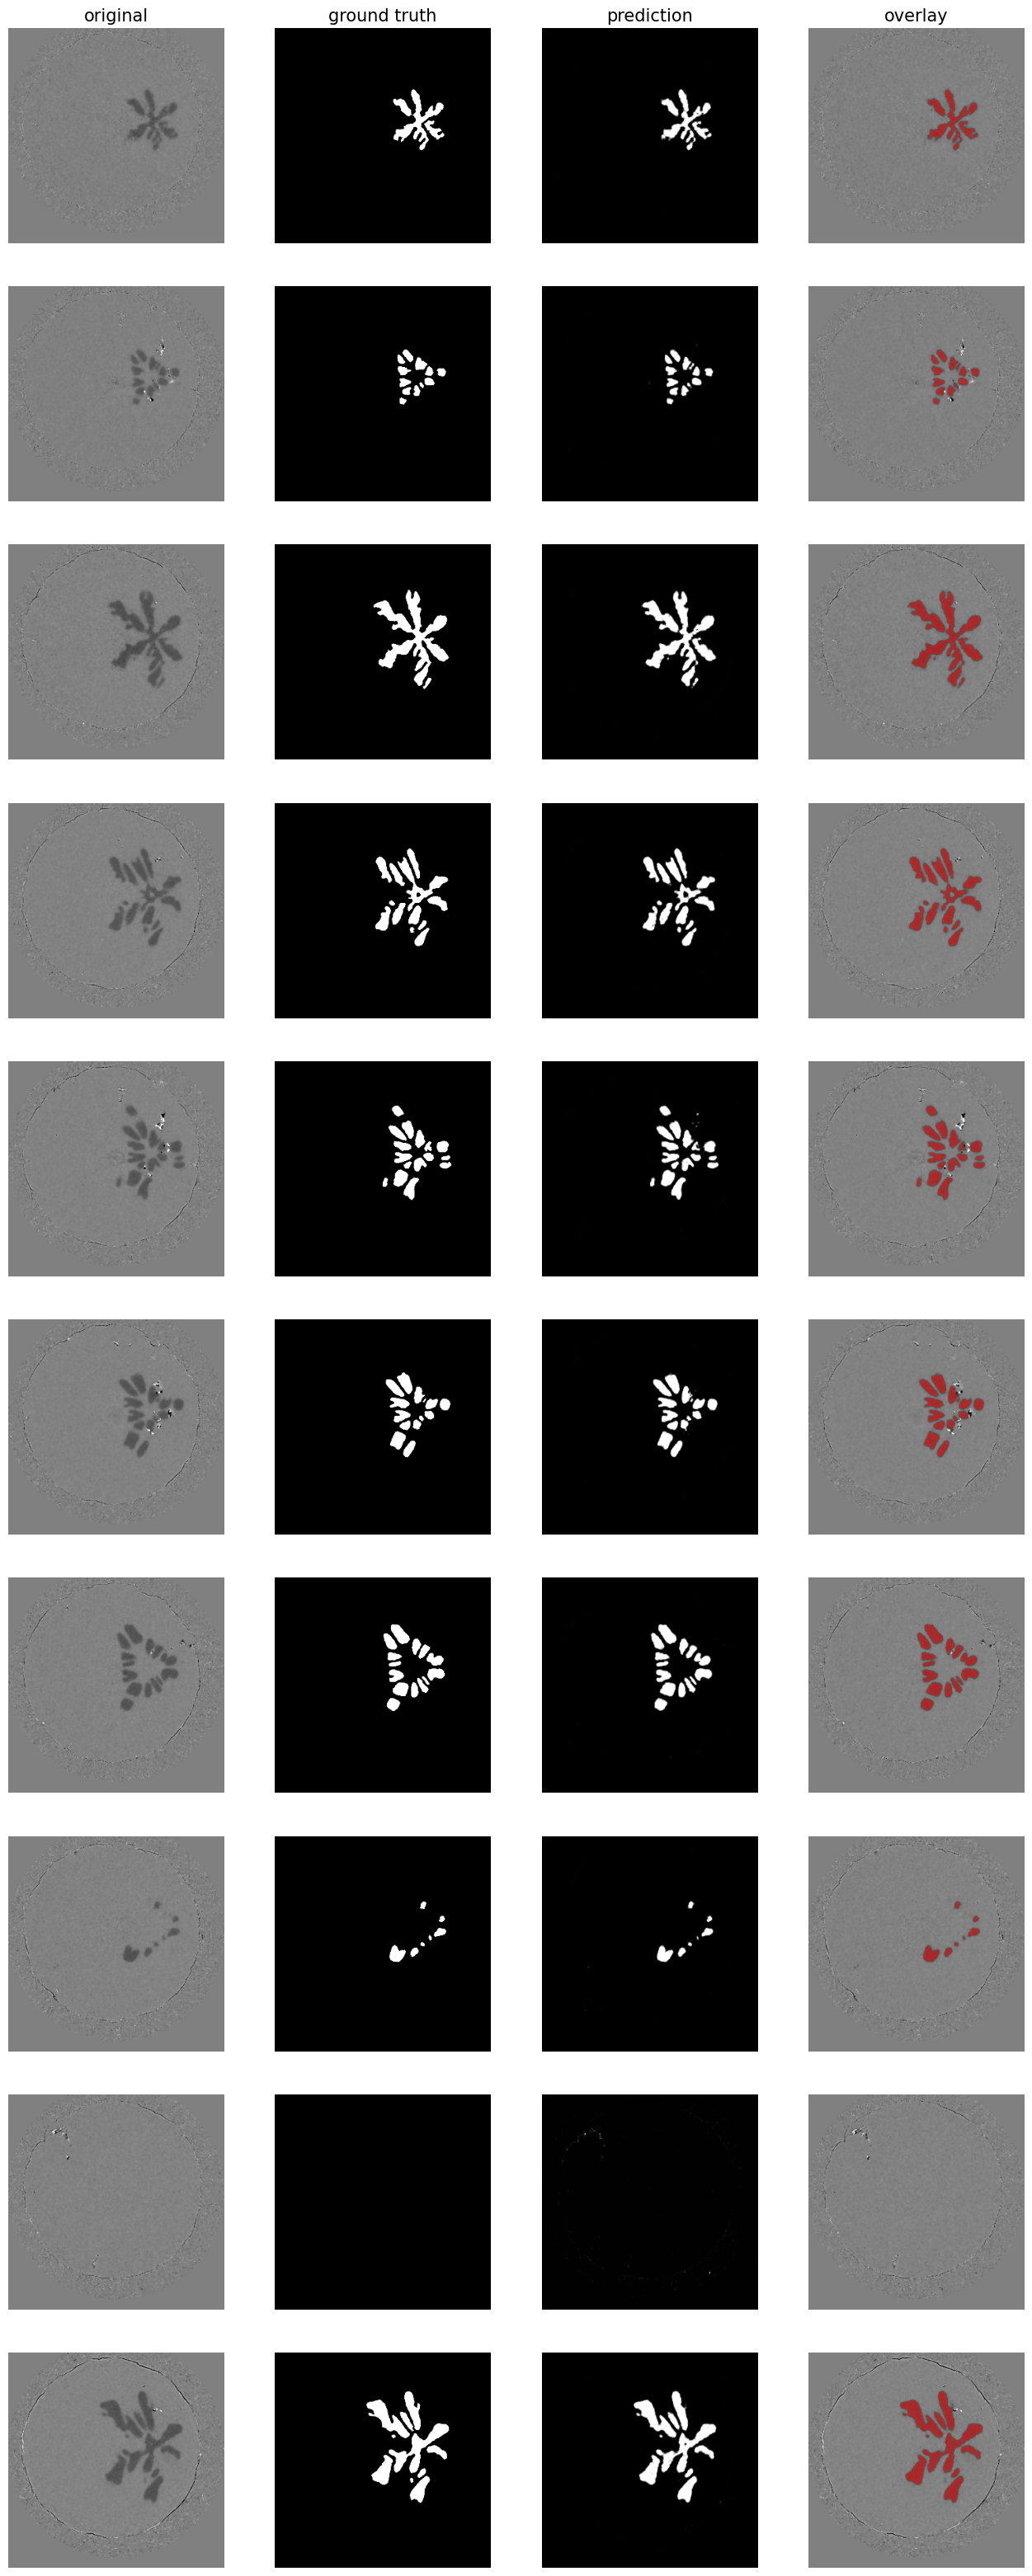

In [33]:
plot_imgs(org_imgs=X_r, mask_imgs=y_c, pred_imgs=y_pred, nm_img_to_plot=10)